In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchsampler

In [3]:
# train_b7_multitask_full.py  (with confusion matrices at the end)
import os, random, pandas as pd, torch, torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsampler import ImbalancedDatasetSampler  # pip install torchsampler

In [4]:
# ======== Config ========
CSV_PATH   = "/content/drive/MyDrive/data/streetSurfaceVis_v1_0_2.csv"
IMG_DIR    = "/content/drive/MyDrive/data/s_1024"
BATCH_SIZE = 8
EPOCHS     = 40
LR         = 3e-4
PATIENCE   = 10
NUM_MATERIALS, NUM_QUALITIES = 5, 5
SEED = 42

In [5]:
# ======== Column names ========

import pandas as pd

# Load the CSV file to inspect column names
df_inspect = pd.read_csv(CSV_PATH)
print(df_inspect.columns)

Index(['mapillary_image_id', 'path', 'filepath', 'user_id', 'user_name',
       'captured_at', 'longitude', 'latitude', 'train', 'type',
       'surface_quality'],
      dtype='object')


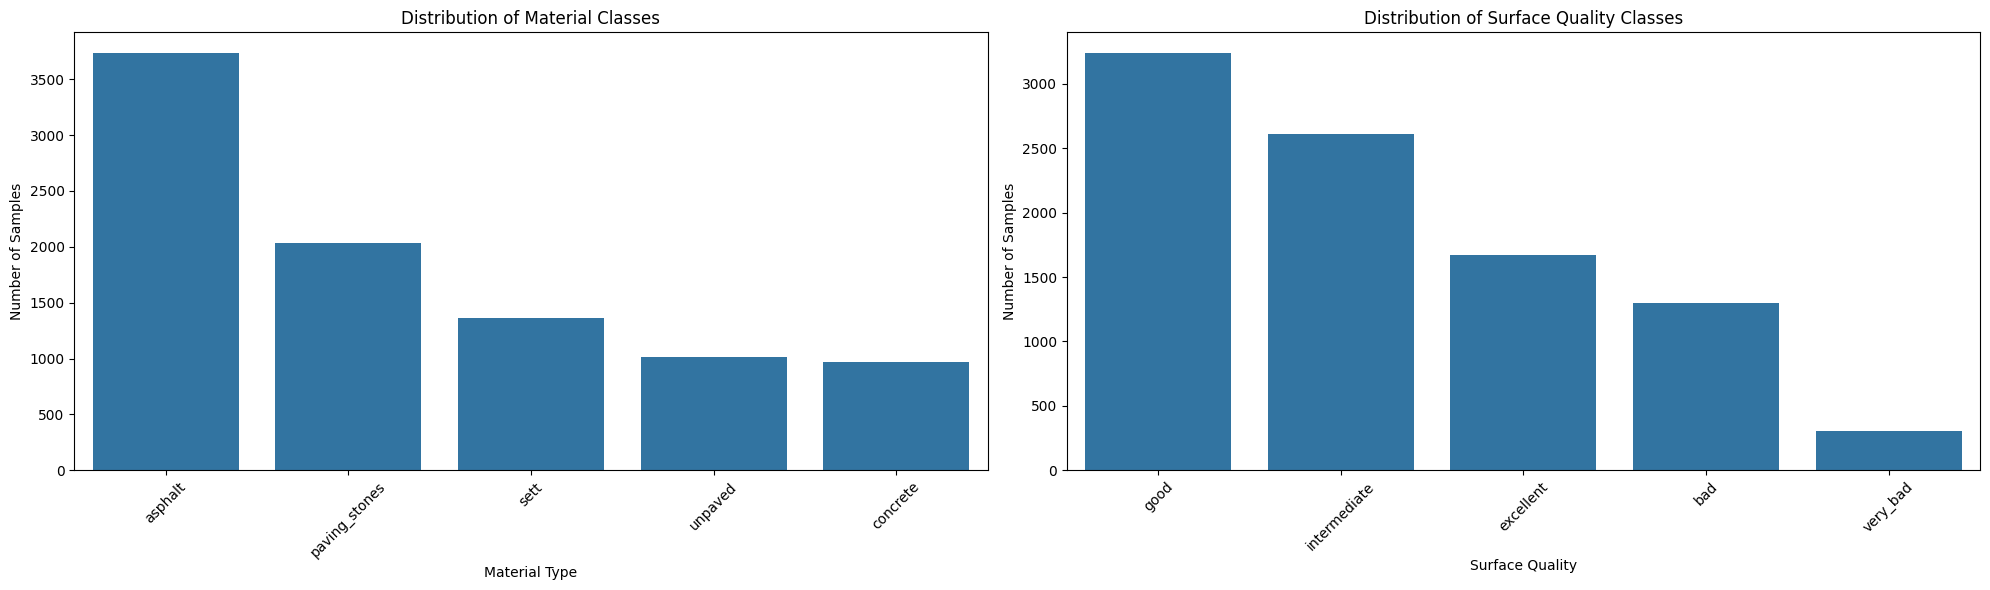

In [6]:
# ======== Data exploration analyis ========

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CSV file
df = pd.read_csv(CSV_PATH)

# Count occurrences for 'type' (material)
material_counts = df['type'].value_counts()

# Count occurrences for 'surface_quality'
quality_counts = df['surface_quality'].value_counts()

# Create subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

# Create bar plot for material classes on the first subplot
sns.barplot(x=material_counts.index, y=material_counts.values, ax=axes[0])
axes[0].set_title('Distribution of Material Classes')
axes[0].set_xlabel('Material Type')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45) # Removed ha='right'

# Create bar plot for quality classes on the second subplot
sns.barplot(x=quality_counts.index, y=quality_counts.values, ax=axes[1])
axes[1].set_title('Distribution of Surface Quality Classes')
axes[1].set_xlabel('Surface Quality')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45) # Removed ha='right'

plt.tight_layout()
plt.show()

In [7]:
# ======== Repro ========
random.seed(SEED); torch.manual_seed(SEED)

# ======== Label maps ========
master_class = {"asphalt":0,"concrete":1,"paving_stones":2,"unpaved":3,"sett":4}
sub_class    = {"excellent":0,"good":1,"intermediate":2,"bad":3,"very_bad":4}
material_names = [k for k,_ in sorted(master_class.items(), key=lambda x:x[1])]
quality_names  = [k for k,_ in sorted(sub_class.items(),   key=lambda x:x[1])]

# ======== Device & speed ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True

In [8]:
# ======== Transforms ========
tfms = transforms.Compose([
    transforms.Resize((600, 600)), # Resize to 600x600 because EfficientNet b7
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [9]:
# ======== Dataset ========
class StreetDS(Dataset):
    def __init__(self, csv_path, img_dir, tfm=tfms):
        df = pd.read_csv(csv_path)
        self.paths = [os.path.join(img_dir, f) for f in df["filepath"]]
        self.mat   = [master_class[m] for m in df["type"]]
        self.qual  = [sub_class[q]    for q in df["surface_quality"]]
        self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        x = self.tfm(Image.open(self.paths[i]).convert("RGB"))
        return x, (torch.tensor(self.mat[i]), torch.tensor(self.qual[i]))

In [10]:
# ======== Split & Loaders (imbalanced sampler on train) ========
ds = StreetDS(CSV_PATH, IMG_DIR)
idx = torch.randperm(len(ds)); n_tr = int(0.8*len(ds))
tr_ds, va_ds = Subset(ds, idx[:n_tr]), Subset(ds, idx[n_tr:])

train_sampler = ImbalancedDatasetSampler(
    tr_ds, callback_get_label=lambda subset: [ds.mat[i] for i in subset.indices]
)
# For joint balance (material, quality), use:
# train_sampler = ImbalancedDatasetSampler(
#     tr_ds, callback_get_label=lambda subset: [(ds.mat[i], ds.qual[i]) for i in subset.indices]
# )


train_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=train_sampler,
                      num_workers=2, pin_memory=True, persistent_workers=True)
val_dl   = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=2, pin_memory=True, persistent_workers=True)

In [11]:
# ======== Model ========
class MultiHeadEffNetB7(nn.Module):
    def __init__(self):
        super().__init__()
        base = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])
        f = base.classifier[1].in_features  # 2560
        self.mat, self.qual = nn.Linear(f, NUM_MATERIALS), nn.Linear(f, NUM_QUALITIES)
    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.mat(x), self.qual(x)

model = MultiHeadEffNetB7().to(device)
try: model = torch.compile(model)
except: pass

opt = torch.optim.AdamW(model.parameters(), lr=LR)
lossfn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)

# AMP
try:
    # Try importing from the newer torch.amp first as recommended by the warning
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
except ImportError:
    # Fallback to the older torch.cuda.amp if torch.amp is not available
    try:
        from torch.cuda.amp import autocast, GradScaler
        scaler = GradScaler()
    except Exception as e:
         # Fallback if neither works, maybe for CPU or very old versions
         print(f"AMP not fully available: {e}, proceeding without it.")
         # Define dummy autocast and GradScaler if AMP is not available
         class autocast:
             def __enter__(self): pass
             def __exit__(self, exc_type, exc_val, exc_tb): pass
         class GradScaler:
             def scale(self, loss): return loss
             def step(self, optimizer): optimizer.step()
             def update(self): pass
         scaler = GradScaler()

In [12]:
# ======== Train / Validate / Early Stop ========
best_metric, wait = -1.0, 0
epoch_metrics = [] # List to store metrics per epoch

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train(); train_loss = 0.0
    for imgs, (mat_y, qual_y) in train_dl:
        imgs = imgs.to(device, non_blocking=True)
        mat_y, qual_y = mat_y.to(device, non_blocking=True), qual_y.to(device, non_blocking=True)
        with autocast(device_type=device.type): # Pass device type to autocast
            m_logits, q_logits = model(imgs)
            loss = lossfn(m_logits, mat_y) + lossfn(q_logits, qual_y)
        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        train_loss += loss.item()

    # ---- Validate ----
    model.eval(); val_loss = 0.0; mat_ok = qual_ok = n = 0
    with torch.no_grad():
        for imgs, (mat_y, qual_y) in val_dl:
            imgs = imgs.to(device, non_blocking=True)
            mat_y, qual_y = mat_y.to(device, non_blocking=True), qual_y.to(device, non_blocking=True)
            with autocast(device_type=device.type): # Pass device type to autocast
                m_logits, q_logits = model(imgs)
                vloss = lossfn(m_logits, mat_y) + lossfn(q_logits, qual_y)
            val_loss += vloss.item()
            mat_ok += (m_logits.argmax(1) == mat_y).sum().item()
            qual_ok += (q_logits.argmax(1) == qual_y).sum().item()
            n += mat_y.size(0)

    mat_acc, qual_acc = (mat_ok/n if n else 0.0), (qual_ok/n if n else 0.0)
    metric = 0.5 * (mat_acc + qual_acc)
    epoch_metrics.append(metric) # Store the metric

    scheduler.step(metric)

    # ---- Save checkpoints & early stop ----
    torch.save(model.state_dict(), f"ckpt_epoch{epoch}.pt")
    if metric > best_metric:
        best_metric, wait = metric, 0
        torch.save(model.state_dict(), "best_model.pt")
        flag = " ✅ best updated"
    else:
        wait += 1; flag = ""

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.3f}  val_loss={val_loss:.3f}  "
          f"mat_acc={mat_acc:.3f}  qual_acc={qual_acc:.3f}  avg_acc={metric:.3f}  "
          f"lr={opt.param_groups[0]['lr']:.2e}{flag}")

    if wait >= PATIENCE:
        print(f"⏹️  Early stopping: no accuracy improvement for {PATIENCE} epochs.")
        break

Epoch 01/40 | train_loss=1257.554  val_loss=279.547  mat_acc=0.899  qual_acc=0.593  avg_acc=0.746  lr=3.00e-04 ✅ best updated
Epoch 02/40 | train_loss=842.255  val_loss=268.475  mat_acc=0.910  qual_acc=0.604  avg_acc=0.757  lr=3.00e-04 ✅ best updated
Epoch 03/40 | train_loss=646.293  val_loss=263.767  mat_acc=0.900  qual_acc=0.673  avg_acc=0.786  lr=3.00e-04 ✅ best updated
Epoch 04/40 | train_loss=521.596  val_loss=293.345  mat_acc=0.906  qual_acc=0.625  avg_acc=0.765  lr=3.00e-04
Epoch 05/40 | train_loss=414.933  val_loss=313.170  mat_acc=0.923  qual_acc=0.640  avg_acc=0.781  lr=3.00e-04
Epoch 06/40 | train_loss=342.362  val_loss=311.824  mat_acc=0.912  qual_acc=0.644  avg_acc=0.778  lr=1.50e-04
Epoch 07/40 | train_loss=191.311  val_loss=329.720  mat_acc=0.924  qual_acc=0.660  avg_acc=0.792  lr=1.50e-04 ✅ best updated
Epoch 08/40 | train_loss=127.188  val_loss=343.068  mat_acc=0.934  qual_acc=0.675  avg_acc=0.804  lr=1.50e-04 ✅ best updated
Epoch 09/40 | train_loss=103.696  val_loss=3

In [ ]:
vc

In [13]:
# ======== Final Evaluation: Confusion Matrices (val set) ========
cm_mat  = torch.zeros(NUM_MATERIALS, NUM_MATERIALS, dtype=torch.int64)  # [true, pred]
cm_qual = torch.zeros(NUM_QUALITIES, NUM_QUALITIES, dtype=torch.int64)

model.eval()
with torch.no_grad():
    for imgs, (mat_y, qual_y) in val_dl:
        imgs = imgs.to(device, non_blocking=True)
        mat_y, qual_y = mat_y.to(device), qual_y.to(device)
        m_logits, q_logits = model(imgs)
        m_pred, q_pred = m_logits.argmax(1), q_logits.argmax(1)
        for t, p in zip(mat_y.view(-1), m_pred.view(-1)):
            cm_mat[t.long(), p.long()] += 1
        for t, p in zip(qual_y.view(-1), q_pred.view(-1)):
            cm_qual[t.long(), p.long()] += 1


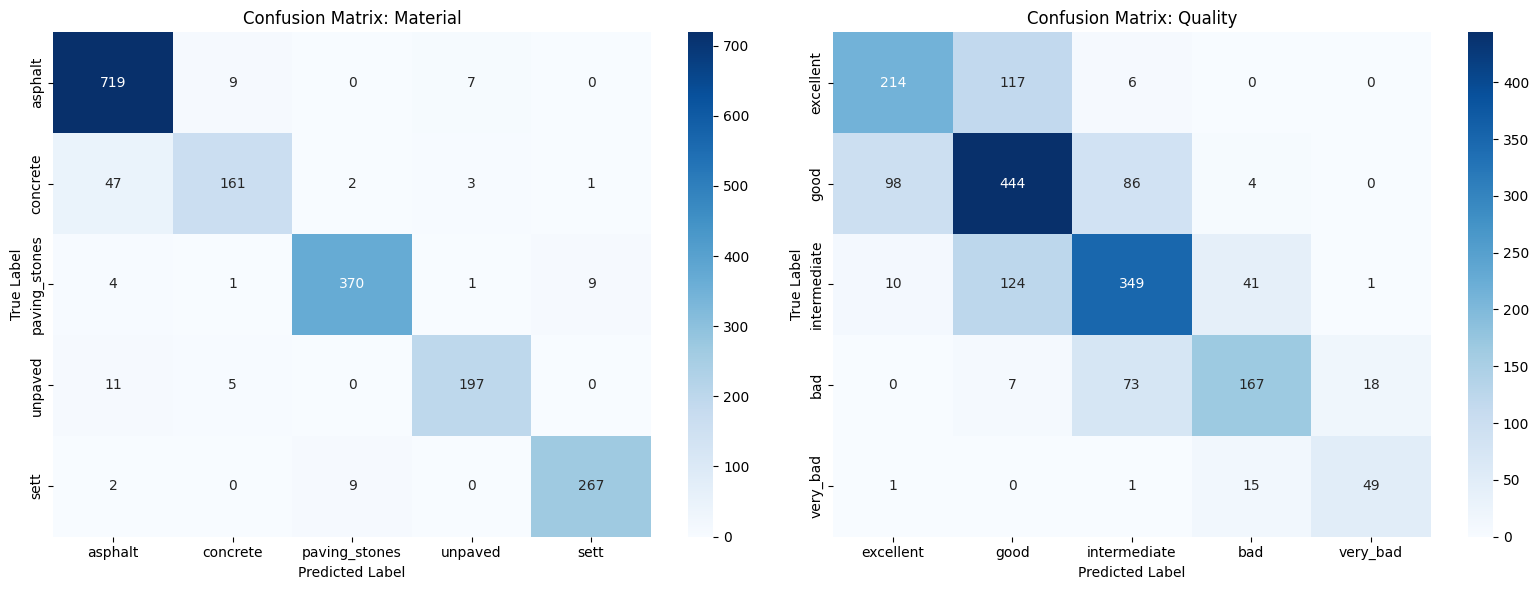

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns

# Plot Material Confusion Matrix
sns.heatmap(cm_mat.cpu().numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=material_names, yticklabels=material_names, ax=axes[0])
axes[0].set_title('Confusion Matrix: Material')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot Quality Confusion Matrix
sns.heatmap(cm_qual.cpu().numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=quality_names, yticklabels=quality_names, ax=axes[1])
axes[1].set_title('Confusion Matrix: Quality')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

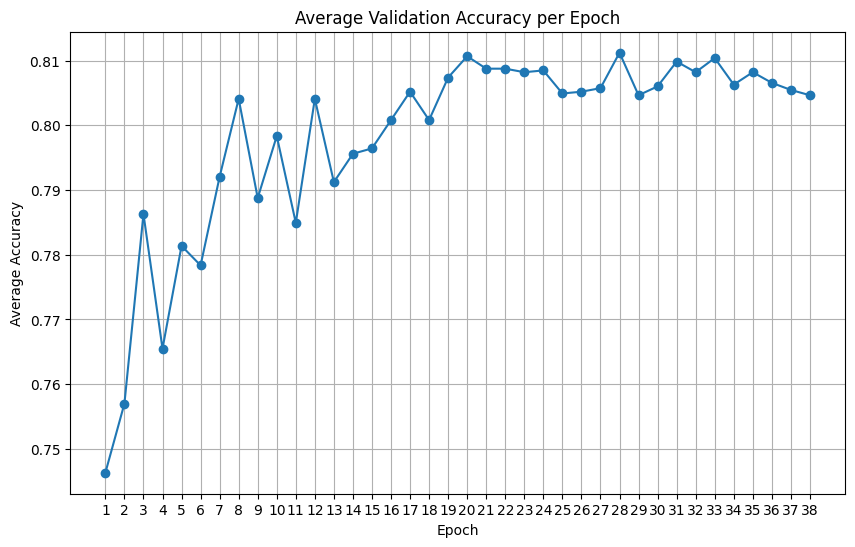

In [15]:
import matplotlib.pyplot as plt

# Assuming epoch_metrics list is available from the training loop execution (cell 2_DfbKh5bcct)

epochs = range(1, len(epoch_metrics) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_metrics, marker='o', linestyle='-')
plt.title('Average Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(epochs) # Ensure all epochs are shown on the x-axis
plt.show()